In [32]:
import pandas as pd
from sklearn.cluster import KMeans,DBSCAN
from sklearn.preprocessing import StandardScaler, Normalizer
import numpy as np
from sklearn.metrics.cluster import silhouette_score #evaluates how good clustering is
from sklearn.model_selection import train_test_split
from sklearn import metrics
import scipy.stats as stats

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.externals.six import StringIO
from sklearn.preprocessing import StandardScaler


#visualizing results
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image
from sklearn.tree import export_graphviz

In [33]:
#Load Data
restdata = pd.read_csv('Restaurant_Inspections.csv')

In [34]:
restdatacleaned = restdata.copy()
#Replace spaces with _ in column names
restdatacleaned.columns = restdata.columns.map(lambda x: x.replace(" ","_"))

In [4]:
restdatacleaned.head()

,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,PHONE,CUISINE_DESCRIPTION,INSPECTION_DATE,ACTION,VIOLATION_CODE,VIOLATION_DESCRIPTION,CRITICAL_FLAG,SCORE,GRADE,GRADE_DATE,RECORD_DATE,INSPECTION_TYPE
0,40393378,E.J LUNCHEONETTE,MANHATTAN,1271,THIRD AVENUE,10021,2124720600,American,07/12/2016,Violations were cited in the following area(s).,02G,Cold food item held above 41Âº F (smoked fish ...,Critical,31.0,NaN,NaN,04/22/2017,Cycle Inspection / Initial Inspection
1,41030615,SERAFINA,MANHATTAN,210,WEST 55 STREET,10019,2123151700,Italian,03/18/2016,Violations were cited in the following area(s).,09C,Food contact surface not properly maintained.,Not Critical,4.0,A,03/18/2016,04/22/2017,Cycle Inspection / Initial Inspection
2,40871795,WONDEE SIAM II,MANHATTAN,813,9 AVENUE,10019,9172861726,Thai,12/23/2015,Violations were cited in the following area(s).,02B,Hot food item not held at or above 140Âº F.,Critical,29.0,NaN,NaN,04/22/2017,Cycle Inspection / Initial Inspection
3,40750612,STROKOS PIZZA DELI,MANHATTAN,888,10 AVENUE,10019,2125816262,American,09/20/2016,Violations were cited in the following area(s).,10B,Plumbing not properly installed or maintained;...,Not Critical,13.0,A,09/20/2016,04/22/2017,Cycle Inspection / Initial Inspection
4,50036944,AMBER,MANHATTAN,103,W 70TH ST,10023,2127998100,Asian,11/12/2015,Violations were cited in the following area(s).,09B,Thawing procedures improper.,Not Critical,9.0,A,11/12/2015,04/22/2017,Pre-permit (Operational) / Re-inspection


In [35]:
#clean up column names by lowercasing them
restdatacleaned.columns = restdatacleaned.columns.str.lower()


In [36]:
#Investigate Data types
restdatacleaned.dtypes

camis                      int64
dba                       object
boro                      object
building                  object
street                    object
zipcode                    int64
phone                     object
cuisine_description       object
inspection_date           object
action                    object
violation_code            object
violation_description     object
critical_flag             object
score                    float64
grade                     object
grade_date                object
record_date               object
inspection_type           object
dtype: object

In [39]:
#Drop columns that don't add to analysis
restdatacleaned = restdatacleaned.drop(['camis','dba','inspection_date','building','street','phone','zipcode','action','violation_description','grade_date','record_date','inspection_type','grade'], axis=1)

In [40]:
#Drop all na values
restdatacleaned = restdatacleaned.dropna()

In [41]:
#convert score column to integer
restdatacleaned.score = restdatacleaned.score.astype(int)

In [42]:
#drop letter character from violation_code to convert to #
restdatacleaned['violation_code'].replace(regex=True,inplace=True,to_replace=r'\D',value=r'')

#most common violation_code
restdatacleaned.violation_code.value_counts(dropna=False)


10    6803
06    5488
04    5450
02    3793
08    2930
09     668
05     326
03      43
22      21
07       3
16       1
Name: violation_code, dtype: int64

In [43]:
criticalflag_dummies = pd.get_dummies(restdatacleaned.critical_flag).astype(int)
criticalflag_dummies.head()

restdatacleaned = pd.concat([restdatacleaned,criticalflag_dummies],axis=1)
restdatacleaned.drop("critical_flag",inplace=True,axis=1)
restdatacleaned.head()

,boro,cuisine_description,violation_code,score,Critical,Not Applicable,Not Critical
0,MANHATTAN,American,02,31,1,0,0
1,MANHATTAN,Italian,09,4,0,0,1
2,MANHATTAN,Thai,02,29,1,0,0
3,MANHATTAN,American,10,13,0,0,1
4,MANHATTAN,Asian,09,9,0,0,1


In [54]:
#There are 62 different cuisines. To simplify dataset, we are going to examine the cuisines that make up 80% of the dataset
#Top 17
restdatacuisinefilter = restdatacleaned.cuisine_description.value_counts(dropna=False)[1:18].index.valuesrestdatacuisinefilter

array(['Italian', 'Chinese', 'Japanese', 'Caf\xc3\x83\xc2\xa9/Coffee/Tea',
       'Pizza', 'Mexican', 'French', 'Indian',
       'Latin (Cuban, Dominican, Puerto Rican, South & Central American)',
       'Thai', 'Delicatessen', 'Pizza/Italian', 'Asian', 'Bakery',
       'Mediterranean', 'Irish', 'Jewish/Kosher'], dtype=object)

In [ ]:
#Remove reuslts with not applicable?


In [29]:
restdatacleaned.dtypes

boro                   object
cuisine_description    object
violation_code         object
critical_flag          object
score                   int64
dtype: object

In [44]:
Rearrange columns

'''
restdatacleaned_cols = restdatacleaned.columns.tolist()
restdatacleaned_colsselect = restdatacleaned_cols[2:5]+restdatacleaned_cols[0:2]
restdatacleaned_colsselect

restdatacleaned = restdatacleaned[restdatacleaned_colsselect]
restdatacleaned.head()
'''

,violation_code,critical_flag,score,boro,cuisine_description
0,02,Critical,31,MANHATTAN,American
1,09,Not Critical,4,MANHATTAN,Italian
2,02,Critical,29,MANHATTAN,Thai
3,10,Not Critical,13,MANHATTAN,American
4,09,Not Critical,9,MANHATTAN,Asian


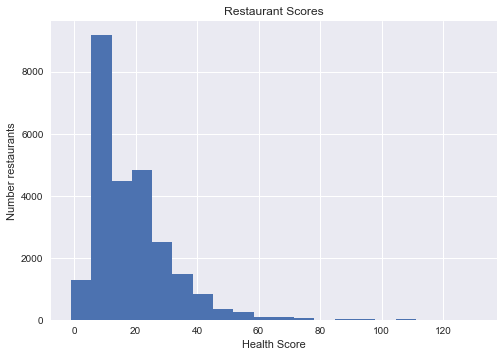

In [46]:
#Expand borrough

restdatacleaned.score.hist(bins=20)
sns.plt.title("Restaurant Scores")
sns.plt.ylabel("Number restaurants")
sns.plt.xlabel("Health Score")



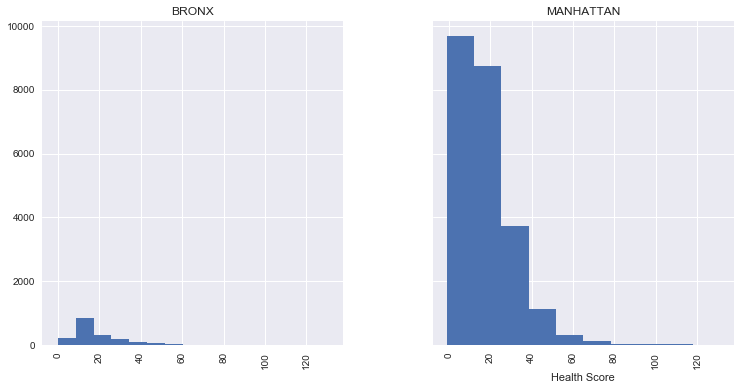

In [53]:
restdatacleaned.hist(by=restdatacleaned["boro"],bins=10,layout= (1,2),figsize=(12,6),sharex=True,sharey=True)
sns.plt.ylabel("Number restaurants")
sns.plt.xlabel("Health Score")

In [213]:
restdatacuisine = restdatacleaned.merge(cusineDF,left_index=True,right_index=True

In [ ]:
#Convert critical to flag
#Convert boros to columns
#Convert cuisines to columns
#Use decsion trees or random forrest